In [1]:
%load_ext notexbook
%texify

# Dataset Partitioning

## Data Partitioning in Machine Learning

To evaluate how well **Supervised** models _generalize_, data are usually _partitioned_ into a _training_ and a _test_ set.

![train_test_split](https://raw.githubusercontent.com/leriomaggio/pytorch-beautiful-ml-data/main/4_data_partitioning/imgs/train_test_split.svg)

The *former* is used as the **reference**, and the **only** dataset on which the whole _training process_ of `ML`/`DL` models builds on; whereas the _latter_ is also referred to as the **held-out** dataset, emphasising that this data should be always kept **separate** from the _training data_, 
and only used _afterwards_ to test model *generalisation* capabilities.

On a very similar note, <ins>*training data*</ins> is usually further partitioned into a _validation_ set. This data is used to monitor and validate model's progress during the training, as if it was a 
*development beta version* of a more general test set. In fact, this data is sometimes also referred to as *development set* or 
<ins>_internal_</ins> [\*](#fnstarval) *validation data*.

Therefore, **all** the rules applying to the *test* data, also apply to the *validation* data!

![train_test_split](https://raw.githubusercontent.com/leriomaggio/pytorch-beautiful-ml-data/main/4_data_partitioning/imgs/train_validation_test2.svg)

<span id="fnstarval"><i>$\star$:</i> As opposed to **external** validation data used for *test* partition.</span>
<span class="fn"><i>Source: </i> [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) _from_ **scikit-learn** documentation.</span>

**Note**

It is worth mentioning that the same principles about data partitioning, and their respective roles also applies to any `preprocessing`, and/or any statistics is derived on the data *before* any actual training is performed. 

For example: **Standardising** a datasets is a common requirement for many machine learning models that might behave badly if the individual features do not more or less look like standard normally distributed data. 

To do so, `sklearn` provides the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) _transformer_ in the [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/preprocessing.html) package, which standardise each feature by removing the mean ($\mu$), and scaling to unit variance ($\sigma$).

The standard score of a sample $x$ is calculated as:
$$
z = \frac{(x-\mu)}{\sigma}
$$
where $\mu$ and $\sigma$ are respectively the *mean*, and the *standard deviation* of each feature among all the **training** samples!

Therefore:

**1**: <span class="texbook-turquoise">CORRECT</span> ✅

```python 
X_train, X_test = split(X)
scaler = StandardScaler()
scaler.fit(X_train)  # fit on training data ONLY!
...
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
```

**2**: <span class="texbook-red">**IN**CORRECT</span> ❌

```python 
scaler = StandardScaler()
scaler.fit(X)  # fit on the whole dataset
...
X_train, X_test = split(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
```

In particular, this is <span class="texbook-red">**incorrect**</span> because information from the _training_ set[$^{1}$](#fn1) would leak into the _test_ set, harming the whole principle of using this data to test how well a ML model is able to **generalise** on _unseen_ data. In other words, the _test_ data would not be truly _unseen_ to some extent.
Further examples of `preprocessing` methods as included in `sklearn` can be found in the official [documentation](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py).


<span id="fn1"><i>[1]: </i>Aggregated in the calculation of the $\mu$ and $\sigma$ parameters used for standardisation</span>

Therefore, as a **general rule of thumb**: _always apply data partitioning before anything else_.

To do so, `sklearn` provides an easy to use `train_test_split(*arrays, **options)` helper function, which wraps `(1)` input validation; and `(2)` the use of a more articulate and generic `ShuffleSplit.split` generator, i.e. `next(ShuffleSplit().split(X, y))` 

In this notebook, we will see how we can combine this, and more complex methods for data partitioning with `torch.utils.data.Dataset` objects, and its corresponding `DataLoaders`.

### `Wine` Dataset Example

In order to understand how data partitioning is performed in _standard_ Machine learning settings, we will use the
**Wine Recognition Dataset** as included in `sklearn` as our reference dataset 

In [2]:
from sklearn.datasets import load_wine

In [3]:
wine = load_wine()

In [4]:
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

In [5]:
X, y = wine.data, wine.target

In [6]:
y_names = wine.target_names
y_names

array(['class_0', 'class_1', 'class_2'], dtype='<U7')

In [7]:
X.shape, y.shape

((178, 13), (178,))

The dataset contains `178` samples (each characterised by `13` features), to be classified in `3` classes

In [8]:
from collections import Counter

samples_per_class = Counter(y)
samples_per_class

Counter({0: 59, 1: 71, 2: 48})

### Random Splitting

The most obvious way to split the dataset in two partitions (_training_ and _test_) is to resort to the _good ol' random splitting_. 

In particular, we could _shuffle_ our labels, and then randomly assign them to either partition. We just need to make sure that we have full control of the _(pseudo-)random_ generation, so that the whole assignment is fully repeatable!

To do so, we could either fix a **global random seed**, or use our own [`numpy.random.Generator`](https://numpy.org/doc/stable/reference/random/generator.html) [\*](#fnnote).

<span class="fn">**[\*]**: Always the solution to prefer, to have full control of random components, _ed._</span>

In [9]:
import numpy as np

SEED = 123456
rng = np.random.RandomState(seed=SEED)

<span class="fn">**[$\dagger$]**: Here we used a _legacy_ `numpy.random.RandomState` generator, as this is the one currently supported in `sklearn`. <br /> Alternatively, we could use `rng = np.random.default_rng(seed=SEED)` to instantiate the more up to date `Generator` object.</span>

In [10]:
shuffled_indices = rng.permutation(np.arange(len(y)))
test_size = 0.25  # We decide how big should be the test partition (alt. training_partition)
test_size_index = int(len(y) * test_size)

X_train, X_test = X[shuffled_indices[:-test_size_index]], X[shuffled_indices[-test_size_index:]]
y_train, y_test = y[shuffled_indices[:-test_size_index]], y[shuffled_indices[-test_size_index:]]

In [11]:
shuffled_indices

array([  9,  38,  76,  86, 163, 146, 118,  93, 170,   7, 151,  88, 129,
        90,  28, 123, 115,  50, 105, 166,  80,  27, 106, 131,  64,  69,
        46,  72,  14,  54, 155,  89,  21, 104,  16, 141, 175,  97,  63,
       165, 124,  15, 122,  40,   3,  77, 168, 133, 157, 145,  26, 130,
       132, 117,  57,  41,  55, 162,   8,  37, 135, 173,  23, 111,  17,
        22, 147,  79,   2, 127,  74, 108,  11,  78, 176,  35,  19, 149,
        73,  61,  82,   1, 112, 100, 134,  13,  96, 154, 169, 109, 107,
        87, 161, 152, 121,  66,  70,  33, 139,  58,  39, 126, 150, 177,
        59,   6,  31,   5,  48,  36, 167,   0,  44, 125, 103,  24,  67,
       128,  81,  29,  45,  71, 159, 153, 148, 160, 113, 137, 174,  99,
        51,  62,  25,  30,  83, 120,  53, 101,  60, 156, 158, 114,   4,
        95, 110,  52,  85, 140,  92, 138,  84, 172, 143,  18,  98, 144,
       116,  94,  68,  42, 142,  34, 119, 102,  47,  20,  75,  12,  10,
       136, 164,  32,  91,  43, 171,  56,  49,  65])

In [12]:
y_train, y_test

(array([0, 0, 1, 1, 2, 2, 1, 1, 2, 0, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 1, 0,
        1, 2, 1, 1, 0, 1, 0, 0, 2, 1, 0, 1, 0, 2, 2, 1, 1, 2, 1, 0, 1, 0,
        0, 1, 2, 2, 2, 2, 0, 2, 2, 1, 0, 0, 0, 2, 0, 0, 2, 2, 0, 1, 0, 0,
        2, 1, 0, 1, 1, 1, 0, 1, 2, 0, 0, 2, 1, 1, 1, 0, 1, 1, 2, 0, 1, 2,
        2, 1, 1, 1, 2, 2, 1, 1, 1, 0, 2, 0, 0, 1, 2, 2, 1, 0, 0, 0, 0, 0,
        2, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 2, 2, 2, 2, 1, 2, 2, 1, 0, 1,
        0, 0]),
 array([1, 1, 0, 1, 1, 2, 2, 1, 0, 1, 1, 0, 1, 2, 1, 2, 1, 2, 2, 0, 1, 2,
        1, 1, 1, 0, 2, 0, 1, 1, 0, 0, 1, 0, 0, 2, 2, 0, 1, 0, 2, 0, 0, 1]))

Generating these partitions was pretty easy (and also quite straightforward to implement). 

However, to avoid lots of _boilerplate_, `sklearn` provides an utility function to perform exactly the same operations (_and more_), namely `sklearn.model_selection.train_test_split`, which in turn is itself a wrapper around the `sklearn.model_selection.ShuffleSplit` class:

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rng)

In [15]:
y_train, y_test

(array([0, 0, 2, 0, 1, 1, 2, 1, 2, 1, 2, 2, 0, 0, 0, 2, 1, 1, 1, 1, 0, 2,
        0, 2, 2, 0, 0, 2, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1,
        1, 1, 0, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 0, 1, 0, 2, 2, 0, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 2, 0, 2, 0, 2, 0, 1, 1,
        0, 0, 1, 0, 1, 2, 2, 2, 0, 0, 2, 0, 1, 1, 1, 2, 0, 1, 0, 1, 1, 0,
        1, 0, 0, 2, 1, 1, 1, 2, 2, 0, 0, 1, 1, 2, 2, 0, 2, 1, 2, 1, 0, 1,
        0]),
 array([1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 1, 1,
        1, 2, 2, 1, 0, 2, 2, 2, 0, 1, 2, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 2,
        2]))

**Note**: Passing in the same `RandomState` generator, we obtained _exactly the same_ partitions!

#### Stratification Gotcha

There is a gotcha with the previous example: the random splitting did not take into account samples distribution among the partitions. It was, in fact, purely _random_. 

Sample distributions per-class among partitions might be though an important piece of information to keep in mind, especially if we are going to work with a (quite) imbalanced data (_not really the case here, though_, ed.)

In [16]:
train_counter = Counter(y_train)
train_counter

Counter({0: 46, 2: 32, 1: 55})

In [17]:
test_counter = Counter(y_test)
test_counter

Counter({1: 16, 0: 13, 2: 16})

To account for sample distribution, we could just pass on an additional `stratify` parameter to the `train_test_split` function [$\mp$](#fnstratify)

<span id="fnstratify">This makes the internal implementation to switch wrapping from `ShuffleSplit` to `StratifiedShuffleSplit`  (see [here](https://github.com/scikit-learn/scikit-learn/blob/95119c13af77c76e150b753485c662b7c52a41a2/sklearn/model_selection/_split.py#L2188)) </span>

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                    random_state=rng, stratify=y)

In [19]:
train_stratified_count = Counter(y_train)
train_stratified_count

Counter({0: 44, 1: 53, 2: 36})

In [20]:
test_stratified_count = Counter(y_test)
test_stratified_count

Counter({2: 12, 1: 18, 0: 15})

In [21]:
samples_per_class

Counter({0: 59, 1: 71, 2: 48})

## Cross-Validation

By partitioning the available data into three sets (i.e. _train_, _validation_, _test_), we 
drastically reduce the number of samples which are using for learning the model, 
and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this issue is a procedure called **Cross Validation** (`CV` in short). In cross-validation, the data is split repeatedly into a **training** and **test-set**, with a separate model built for every pair. 
The test-set scores are then aggregated for a more robust estimate.

In more details:

(from [Wikipedia](https://en.wikipedia.org/wiki/Cross-validation_(statistics)))

> Cross-validation, sometimes called **rotation estimation**, or *out-of-sample testing*, 
> is (*a*) model validation technique for assessing how the results 
> of a statistical analysis will generalize to an independent data set.
> [$\ldots$]
> The **goal** of cross-validation is to test the model's ability 
> to predict new data that was not used in estimating it, in order to **flag problems** like 
> <ins>overfitting or selection bias</ins>.



### How does `CV` works?

A **test set** is still **held out** for <ins>final evaluation</ins>, but the *validation set* is no longer intended as a single partition, in the `CV` strategy. 

In the most general settings, (i.e. `k-fold CV`), the _training set_ is split into **k smaller sets**, so that:

1. Select $k-1$ folds for training, $1$ fold for validation;
2. A model is **trained** using the selected $k - 1$ folds of the data;
3. the model is **validated** on the remaining $k_{th}$ fold kept out.
4. Repeat this process again (**<ins>re-initialising all model parameters</ins>**) by applying a different selection to the folds for training/validation **until** all the folds has been used once for validation.

5. Aggregate results for each data partitioning, and derive statistics (with confidence intervals) on model predictions and generalisation capabilities.

The most common way to do cross-validation is **k-fold cross-validation**, in which the data is first split into k (often 5 or 10) equal-sized folds, and then for each iteration, one of the k folds is used as test data, and the rest as training data:

#### K-Fold Cross Validation Partitions

![cross_validation](https://raw.githubusercontent.com/leriomaggio/pytorch-beautiful-ml-data/main/4_data_partitioning/imgs/cross_validation.svg)

<span class="fn"><i>Source: </i> [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) _from_ **scikit-learn** documentation.</span>

There exist multiple strategies (or variations) on how folds can be generated during a `CV`, and the [`sklearn.model_selection`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) package provides classes and functions to handle different partitioning strategies, and data configurations. 

Among the many brilliant examples provided in `sklearn` documentation, I would strongly recommend 
[Visualizing cross-validation behaviour in scikit-learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html), which practically shows the effect of different data selection strategies when creating folds.

In the rest of this notebook, we will build on a similar idea, showing mainly the difference in samples selection when applying a `KFold` and a `StratifiedKFold` cross-validation strategy.

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline

def plot_cv(cv, X, y):
    """Helper function to plot results of the given CV selection"""
    masks = []
    for train, test in cv.split(X, y):
        mask = np.zeros_like(y, dtype=bool)
        mask[test] = 1
        masks.append(mask)
        
    plt.matshow(masks)

First, replicate previous results on `wine` dataset, but this time directly using the `ShuffleSplit` (and `StratifiedShuffleSplit`)

In [23]:
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

In [24]:
# Configuration Settings shared among all the CV objects
N_SPLITS = 50
TEST_SIZE = test_size
RANDOM_STATE = rng

##### `ShuffleSplit`

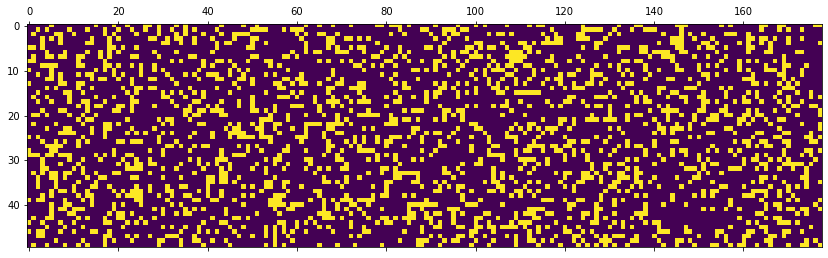

In [25]:
plot_cv(ShuffleSplit(n_splits=N_SPLITS, test_size=TEST_SIZE, random_state=RANDOM_STATE), 
        wine.data, wine.target)

##### `StratifiedShuffleSplit`

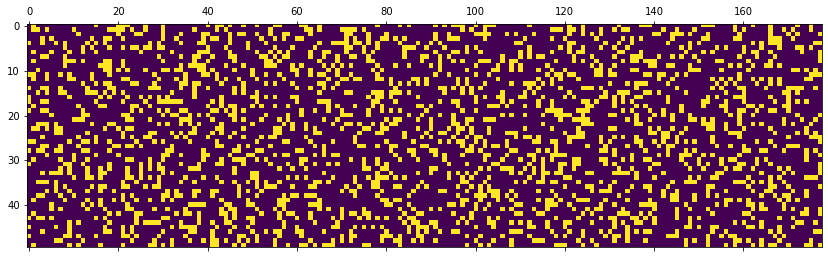

In [26]:
plot_cv(StratifiedShuffleSplit(n_splits=N_SPLITS, test_size=TEST_SIZE, random_state=RANDOM_STATE), 
        wine.data, wine.target)

##### `KFold`

In [27]:
from sklearn.model_selection import KFold, StratifiedKFold

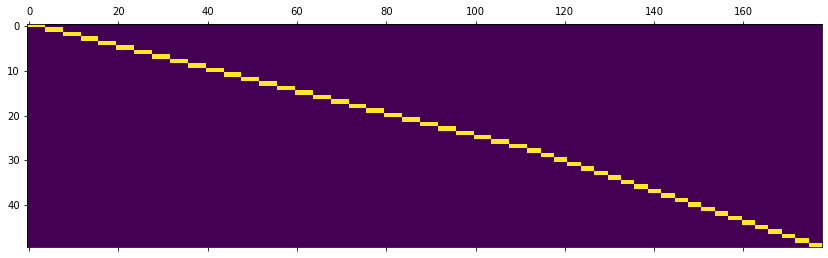

In [28]:
# no shuffling
plot_cv(KFold(n_splits=N_SPLITS), wine.data, wine.target)

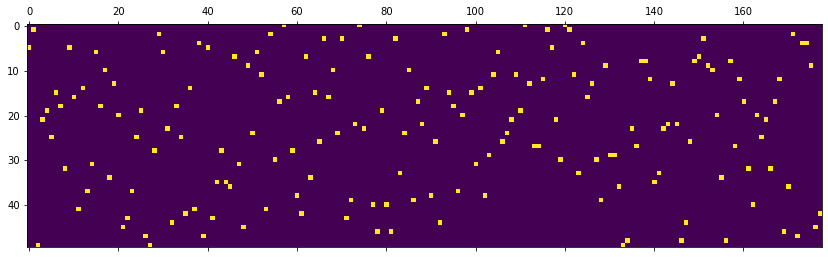

In [29]:
# with shuffling
plot_cv(KFold(n_splits=N_SPLITS, random_state=RANDOM_STATE, shuffle=True), 
        wine.data, wine.target)

##### `StratifiedKFold`

/Users/valerio/anaconda3/envs/dl-datascience/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 48 members, which is less than n_splits=50.
  warnings.warn(("The least populated class in y has only %d"


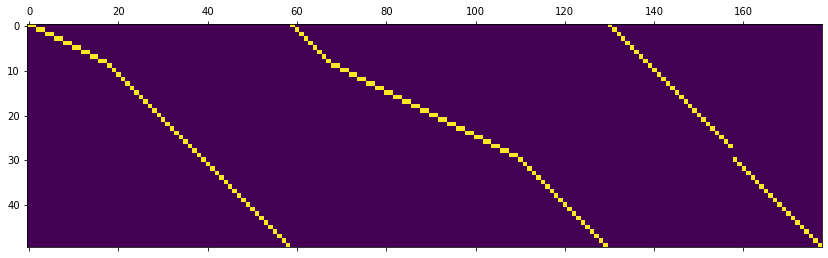

In [30]:
# no shuffling
plot_cv(StratifiedKFold(n_splits=N_SPLITS), wine.data, wine.target)

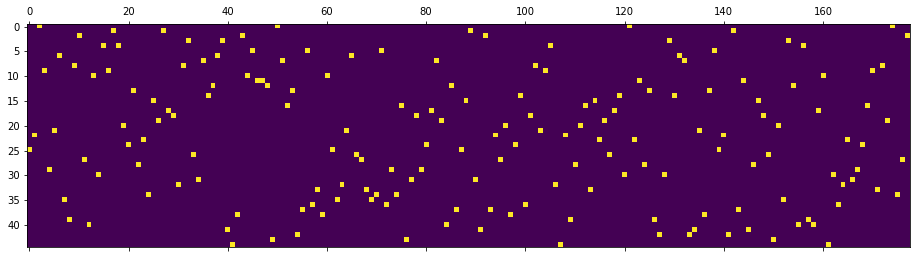

In [31]:
# with shuffling
plot_cv(StratifiedKFold(n_splits=45, random_state=RANDOM_STATE, shuffle=True), 
        wine.data, wine.target)

##### `RepeatedKFold`

In [32]:
from sklearn.model_selection import RepeatedKFold

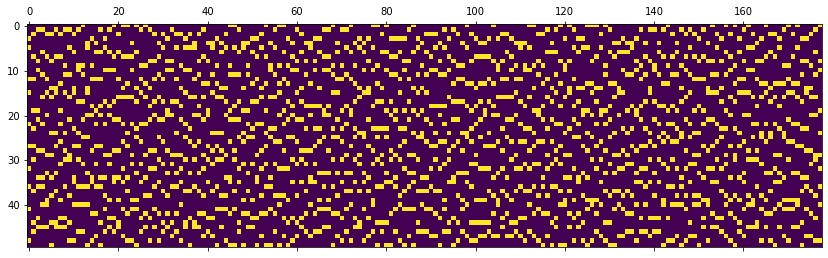

In [33]:
NSPLITS_CV = 5
NREPEAT_CV = 10

plot_cv(RepeatedKFold(n_splits=NSPLITS_CV, n_repeats=NREPEAT_CV, random_state=RANDOM_STATE), 
        wine.data, wine.target)

##### `RepeatedStratifiedKFold`

In [34]:
from sklearn.model_selection import RepeatedStratifiedKFold

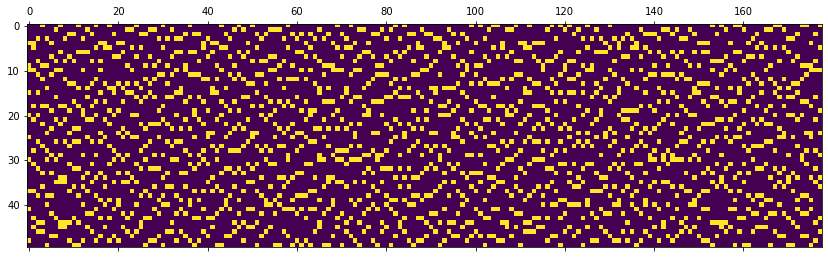

In [35]:
plot_cv(RepeatedStratifiedKFold(n_splits=NSPLITS_CV, n_repeats=NREPEAT_CV, random_state=RANDOM_STATE), 
        wine.data, wine.target)